# Visualization cRTRBM

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from tqdm import tqdm
import h5py
plt.rcParams['figure.figsize'] = [10, 5]

import sys
sys.path.append(r'D:\RU\OneDrive\Intern\Master')

%matplotlib inline
from data.manipulate_data import *
from utils.plots import * 
from RTRBM_batches_in_funcs import RTRBM
from utils.funcs import *
from utils.visualize_hidden_network import *

In [2]:
data = h5py.File('D:\RU\OneDrive\Intern\Master\data/subject_1_reconv_spikes.h5', 'r')
data = data['Data']
print(list(data.keys()))

spikes = torch.tensor(data['spikes'])
xyz = torch.tensor(data['coords'])
N_V, T = spikes.shape
spikes.shape

['behavior', 'coords', 'df', 'spikes', 'stimulus']


torch.Size([83205, 2880])

Delete all neurons that dont fire

In [3]:
xyz = xyz[torch.sum(spikes,1)!=0, :]
spikes = spikes[torch.sum(spikes,1)!=0, :]
N_V, T = spikes.shape
spikes.shape

torch.Size([78239, 2880])

Dont take all the neurons for now but take the mean firing rate per voxel as one neuron

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.48it/s]


torch.Size([539, 2880]) tensor(0.1024)


<AxesSubplot:>

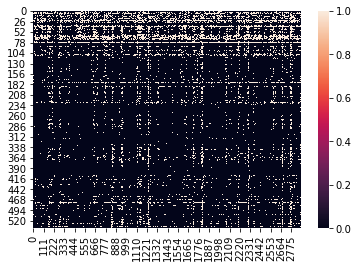

In [4]:
[voxel_spike, voxel_xyz] =  make_voxel_xyz(n = 10, spikes = spikes, xyz = xyz , mode = 3, fraction = 0.1)
spike_thres = 0.15
voxel_spike[voxel_spike>spike_thres] = 1
voxel_spike[voxel_spike<spike_thres] = 0
N_V, T = voxel_spike.shape
print(voxel_spike.shape, torch.sum(voxel_spike / (voxel_spike.shape[0] * voxel_spike.shape[1])))
sns.heatmap(voxel_spike)

## Brain activity over time

<IPython.core.display.Javascript object>


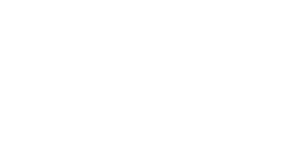

In [5]:
%matplotlib notebook

import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D


snapshots_spikes = [ voxel_spike[:, t] for t in range(T) ] 

#plt.clf()
fig, ax = plt.subplots(figsize=(8,8))
ax = Axes3D(fig)

scat = ax.scatter(voxel_xyz[:, 0], voxel_xyz[:, 1], voxel_xyz[:, 2],
               s=20,
               c = snapshots_spikes[0])
# add another axes at the top left corner of the figure
axtext = fig.add_axes([0.0,0.95,0.1,0.05])

# turn the axis labels/spines/ticks off
axtext.axis("off")

time = axtext.text(0.5,0.5, str(0), ha="left", va="top")

def animate_func(i, data, scat):
    # clear the axis each frame
    ax.clear()

    # replot things
    ax.scatter(voxel_xyz[:, 0], voxel_xyz[:, 1], voxel_xyz[:, 2],
               s=20,
               c = snapshots_spikes[i])
    
    # reformat things
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

    time.set_text(str(i))

    return [time] 

anim = animation.FuncAnimation(
                               fig, 
                               animate_func, 
                               frames = T,
                               interval = 1, # in ms
                               blit=False, fargs=(voxel_spike, scat))
                               
plt.show()

### Create (compositional) RTRBM

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:35<00:00,  1.55s/it]


Text(0, 0.5, 'RMS error')

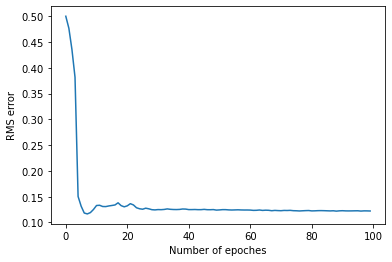

In [6]:
%matplotlib inline
n_epochs = 100
N_H = 16
crtrbm = RTRBM(voxel_spike, N_H = N_H)

crtrbm.learn(
          spars_penalty=3e-4, x=2, sp=True,
          learning_rate=1e-4, learning_rate_decay=False,
          momentum=0.9,
          weightcost=0.0002,
          n_epochs=n_epochs,
          disable_tqdm=False)


plt.plot(crtrbm.errors)
plt.xlabel("Number of epoches")
plt.ylabel("RMS error")

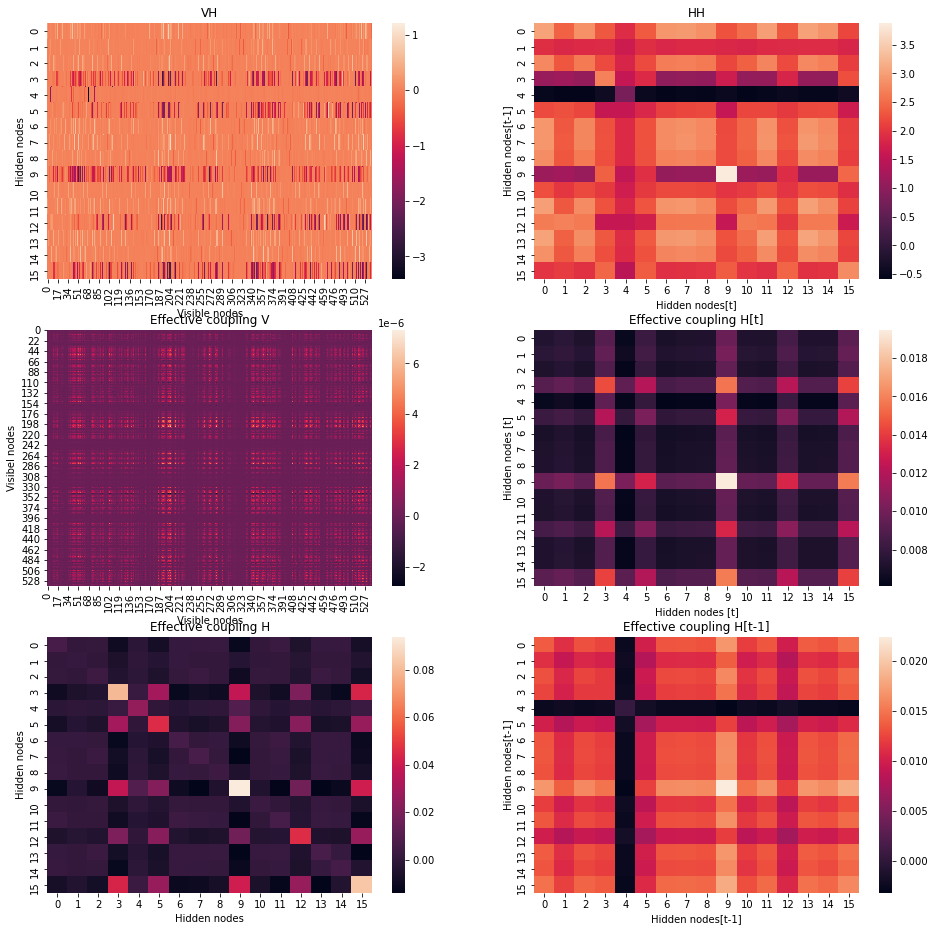

In [7]:
%matplotlib inline
plot_effective_coupling_VH_HH(crtrbm, voxel_spike.float())

### Correlations

C:\Users\Sebastian\anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


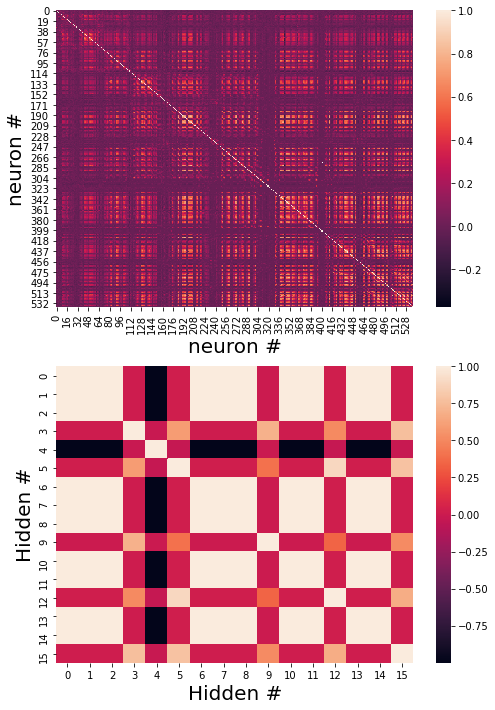

In [8]:
C_v = correlation_matrix(voxel_spike)
C_r = correlation_matrix(crtrbm.visible_to_hidden(voxel_spike.float()))

fig, axes = plt.subplots(2,1, figsize=(8,12))
sns.heatmap(C_v, ax = axes[0])
axes[0].set_xlabel("neuron #",fontsize=20)
axes[0].set_ylabel("neuron #",fontsize=20)

sns.heatmap(C_r, ax = axes[1])
axes[1].set_xlabel("Hidden #",fontsize=20)
axes[1].set_ylabel("Hidden #",fontsize=20)

plt.show()


Cross-correlation

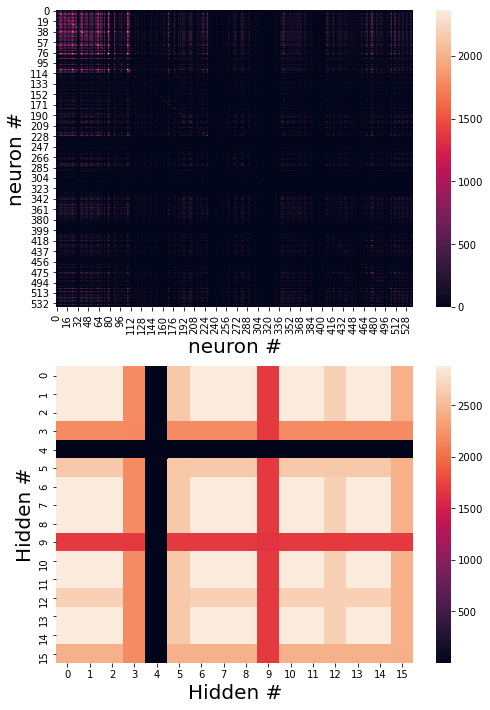

In [9]:
C_v = cross_correlation(voxel_spike)
C_r = cross_correlation(crtrbm.visible_to_hidden(voxel_spike))

fig, axes = plt.subplots(2,1, figsize=(8,12))
sns.heatmap(C_v, ax = axes[0])
axes[0].set_xlabel("neuron #",fontsize=20)
axes[0].set_ylabel("neuron #",fontsize=20)

sns.heatmap(C_r, ax = axes[1])
axes[1].set_xlabel("Hidden #",fontsize=20)
axes[1].set_ylabel("Hidden #",fontsize=20)

plt.show()

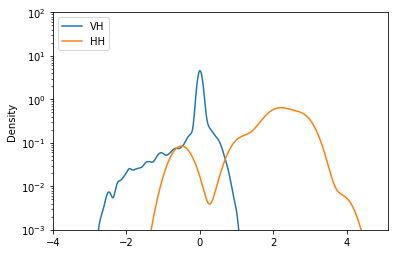

In [11]:
plot_weights_log_distribution_compare(crtrbm.W.T, crtrbm.W_acc.T, label1='VH', label2='HH')

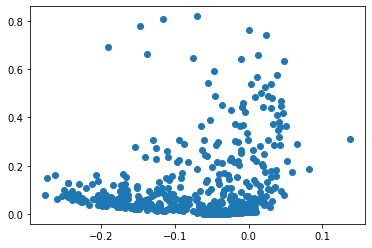

In [12]:
plt.scatter(torch.mean(crtrbm.W,0), torch.mean(voxel_spike,1))

### Receptive field

<IPython.core.display.Javascript object>


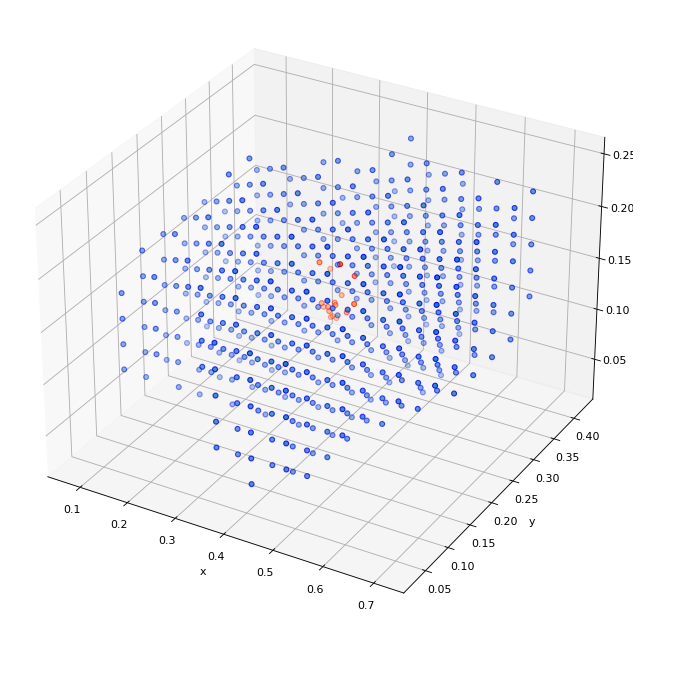

Text(0.5, 0, 'z')

In [20]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D

VH = crtrbm.W.clone()
VH[VH<0] = 0

rf = get_hidden_mean_receptive_fields(VH, voxel_xyz)
fig, ax = plt.subplots(figsize=(8,8))

ax = Axes3D(fig)
ax.scatter(voxel_xyz[:, 0], voxel_xyz[:, 1], voxel_xyz[:, 2], s =20, edgecolors = 'b')
ax.scatter(rf[:, 0], rf[:, 1], rf[:, 2], s=20, edgecolors = 'r')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

RF of all hiddens are in the middle of the graph. Now let do the same approach as in the thesis of thijs: color code each neuron according to its strongest-connecting HU. 

In [21]:
%matplotlib inline

VH = crtrbm.W.detach().clone()
stongest_connecting_HU = torch.zeros(N_V)

for i in range(N_V):
    stongest_connecting_HU[i] = torch.argmax(torch.abs(VH[:,i]))

xyz_visibles_per_HU = []

idx = torch.argsort(stongest_connecting_HU)
num = torch.zeros(N_H+1)
xyz_mean_v_p_HU = torch.zeros(N_H, 3)

for i in range(N_H):
    
    num[i+1] = num[i] + torch.count_nonzero(stongest_connecting_HU == i)
    xyz_visibles_per_HU.append(voxel_xyz[ idx[int(num[i]) : int(num[i+1])] , :])
    xyz_mean_v_p_HU[i,:] = torch.mean(xyz_visibles_per_HU[i],0)

<IPython.core.display.Javascript object>


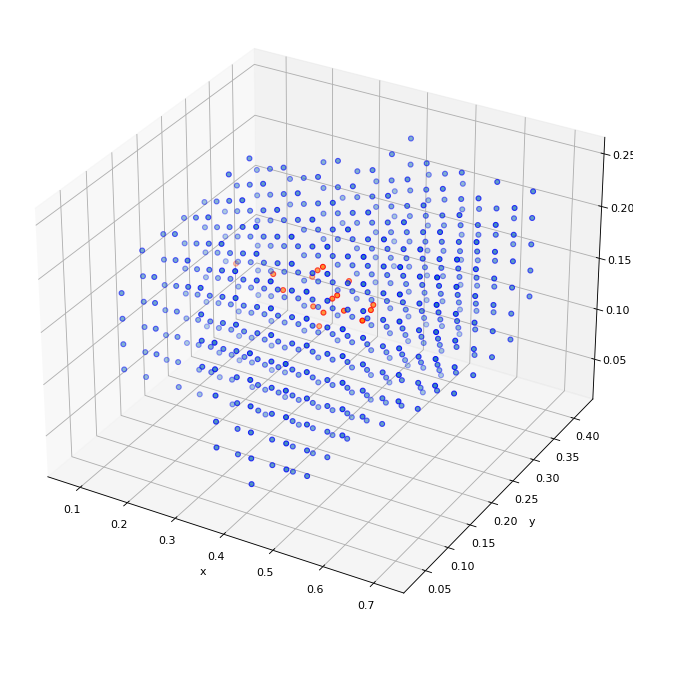

Text(0.5, 0, 'z')

In [22]:
%matplotlib notebook

fig, ax = plt.subplots(figsize=(8,8))

ax = Axes3D(fig)
ax.scatter(voxel_xyz[:, 0], voxel_xyz[:, 1], voxel_xyz[:, 2], s =20, edgecolors = 'b')
ax.scatter(xyz_mean_v_p_HU[:, 0], xyz_mean_v_p_HU[:, 1], xyz_mean_v_p_HU[:, 2], s=20, edgecolors = 'r')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')


<IPython.core.display.Javascript object>


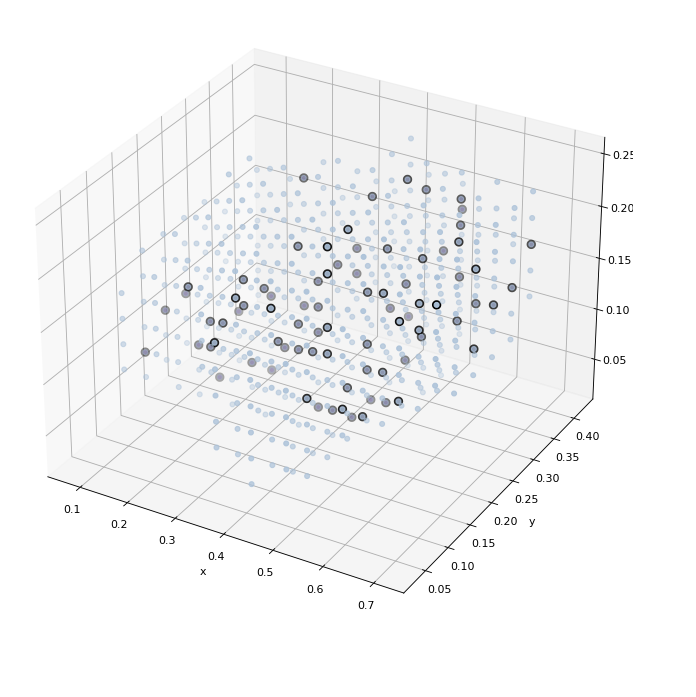

interactive(children=(IntSlider(value=0, description='i', max=15), Output()), _dom_classes=('widget-interact',…

<function __main__.plot_xyz_visibles_per_HU(i)>

In [29]:
import matplotlib.colors as colors
from ipywidgets import interact
import ipywidgets as widgets

#len(colors_list)
colors_list = list(colors._colors_full_map.values())
#color=colors_list[0]

fig, ax = plt.subplots(figsize=(8,8))

ax = Axes3D(fig)

def plot_xyz_visibles_per_HU(i):
#for i in range(N_H):
    ax = Axes3D(fig)
    ax.scatter(voxel_xyz[:, 0], voxel_xyz[:, 1], voxel_xyz[:, 2], s =20, color = colors_list[0])
    ax.scatter(xyz_visibles_per_HU[i][:,0], xyz_visibles_per_HU[i][:,1], xyz_visibles_per_HU[i][:,2], \
               s=20, color=colors_list[20 * (i+1)], edgecolors = 'k', linewidths = 3)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    
interact(plot_xyz_visibles_per_HU, i = widgets.IntSlider(min=0, max=(N_H-1), value=0))


<IPython.core.display.Javascript object>


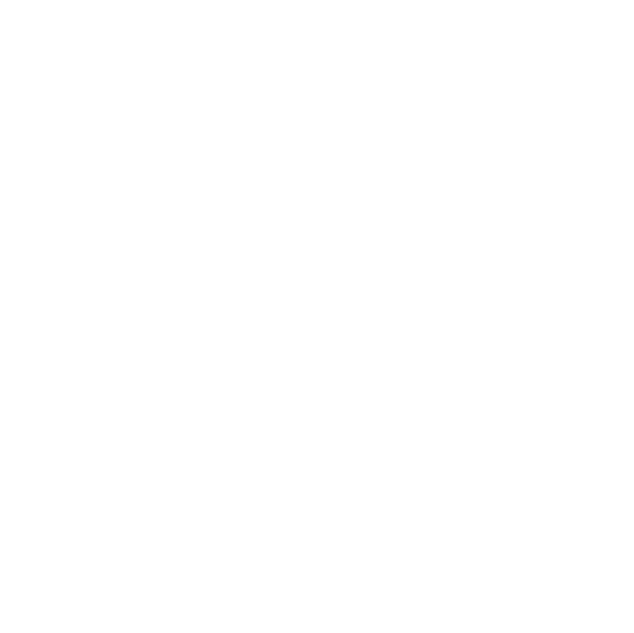

interactive(children=(IntSlider(value=0, description='i', max=15), Output()), _dom_classes=('widget-interact',…

<function __main__.plot_xyz_visibles_per_HU(i)>

In [17]:
#%matplotlib inline

fig, ax = plt.subplots(figsize=(8,8))

def plot_xyz_visibles_per_HU(i):
#for i in range(N_H):
    #ax.scatter(voxel_xyz[:, 0], voxel_xyz[:, 1], voxel_xyz[:, 2], s =20, color = 'y')
    ax.scatter(xyz_visibles_per_HU[i][:,0], xyz_visibles_per_HU[i][:,1], s=20, color=colors_list[20 * i])
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    
interact(plot_xyz_visibles_per_HU, i = widgets.IntSlider(min=0, max=(N_H-1), value=0))


Now such that we can look at 1 HU at a time in 2D

In [18]:
%matplotlib inline

plt.scatter()

TypeError: scatter() missing 2 required positional arguments: 'x' and 'y'

### Create error ellipse for hidden unit visualisation

In [ ]:
rx,ry = error_ellipse(x = voxel_xy[0,:], y = voxel_xy[1,:] , p = 0.9)
plt.scatter(voxel_xy[:,0], voxel_xy[:,1])
plt.plot(rx,ry)